In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from statistics import mean
from scipy import constants as cst
from scipy import signal
from scipy.stats import linregress
from scipy.signal import find_peaks, peak_prominences
from scipy.signal import freqz, lfilter, welch
from scipy import fftpack
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import math
from scipy.constants import find, physical_constants, c
import datetime
import scipy.special
from math import factorial

In [3]:
class PhaseScreenDec:
    def __init__(self, wavelenght, phi0, r0, grid_size, L, Z_lambda):
        self.wavelength = wavelength
        self.k = 2 * np.pi / self.wavelength  # wavenumber
        self.phi0 = phi0  # phi0 (in radians)
        self.L = L  # Length of the observation grid
        self.grid_size = grid_size  # number of grid points
        self.dx = self.L / self.grid_size  # Spatial resolution
        self.x = np.linspace(-self.L / 2, self.L / 2, self.grid_size)
        self.Z_lambda = Z_lambda
        self.r0 = r0
        self.z_values = [z * self.wavelength for z in self.Z_lambda]
        self.phi = -self.phi0 * np.exp(-self.x**2 / (self.r0**2))  

    def generation_of_phase_screen_dec(self):
        U = np.ones(self.grid_size, dtype=complex)  # Initial electric field (plane wave)
        U *= np.exp(1j * self.phi)  # Apply the phase screen
        return U

    def fourier_propagation(self, z_values):
        U_fft = np.fft.fftshift(np.fft.fft(self.generation_of_phase_screen_dec()))
        K = 2 * np.pi * np.fft.fftshift(np.fft.fftfreq(self.grid_size, d=self.dx))
        numerical_results = []
        
        for zi in z_values:
            H = np.exp(1j * zi * K**2 / (2 * self.k) + 1j * K * self.x)
            U_prop = np.exp(-1j * self.k * zi) * np.fft.ifft(np.fft.ifftshift(U_fft * H))
            intensity = np.abs(U_prop)**2
            numerical_results.append(intensity)
        
        return numerical_results


In [4]:
class E_theoretical:
    def __init__(self, phase_screen_dec):
        self.phase_screen_dec = phase_screen_dec

    def calculate_E_theoretical(self, max_n=170):
        I_theory = []
        
        for zi in self.phase_screen_dec.z_values:
            summation = np.zeros_like(self.phase_screen_dec.x, dtype=np.complex128)
            E = np.exp(1j * self.phase_screen_dec.k * zi + 1j * self.phase_screen_dec.k * self.phase_screen_dec.x**2 / (2 * zi)) / np.sqrt(1j * self.phase_screen_dec.k * zi)
            
            for n in range(max_n):
                term = ((1j * self.phase_screen_dec.phi0) ** n) / factorial(n)
                term *= (2 * n / ((self.phase_screen_dec.k * r0)**2) - 1j / (self.phase_screen_dec.k * zi))**-0.5
                term *= np.exp(-self.phase_screen_dec.x**2 / (2 * zi**2) / ((2 * n / ((self.phase_screen_dec.k * r0)**2) - 1j / (self.phase_screen_dec.k * zi))))
                summation += term
            
            E *= summation
            intensity = np.abs(E)**2
            I_theory.append(intensity)
        
        return I_theory

In [5]:
class PlotResultsDec():
    def __init__(self, phase_screen_dec, e_theoretical):
        self.phase_screen_dec = phase_screen_dec
        self.e_theoretical = e_theoretical
        

    def plot_results(self):
        numerical_results = self.phase_screen_dec.fourier_propagation(self.phase_screen_dec.z_values)
        I_theory = self.e_theoretical.calculate_E_theoretical()

        fig, axs = plt.subplots(len(self.phase_screen_dec.z_values), 1, figsize=(10, 25), constrained_layout=True)
        fig.suptitle(r"Grid_size = " + f"{self.phase_screen_dec.grid_size}", fontsize=15)

        for i, (zi, num_intensity, th_intensity) in enumerate(zip(self.phase_screen_dec.Z_lambda, numerical_results, I_theory)):
            axs[i].plot(self.phase_screen_dec.x/self.phase_screen_dec.wavelength, th_intensity, label="Theoretical results", linewidth=4)
            axs[i].plot(self.phase_screen_dec.x/self.phase_screen_dec.wavelength, num_intensity, label="Numerical results", linewidth=4, linestyle="--")
            axs[i].set_title(r"$z / \lambda$ =" + f"{zi}")
            axs[i].set_xlabel(r"Distance $(x / \lambda)$")
            axs[i].set_ylabel("Intensity $|E|^2$")
            axs[i].set_xlim([-10, 10])
            axs[i].set_ylim([0, 8])
            axs[i].legend()
        plt.savefig(f"{self.phase_screen_dec.grid_size}_overlay.png", dpi='figure')
        plt.show()



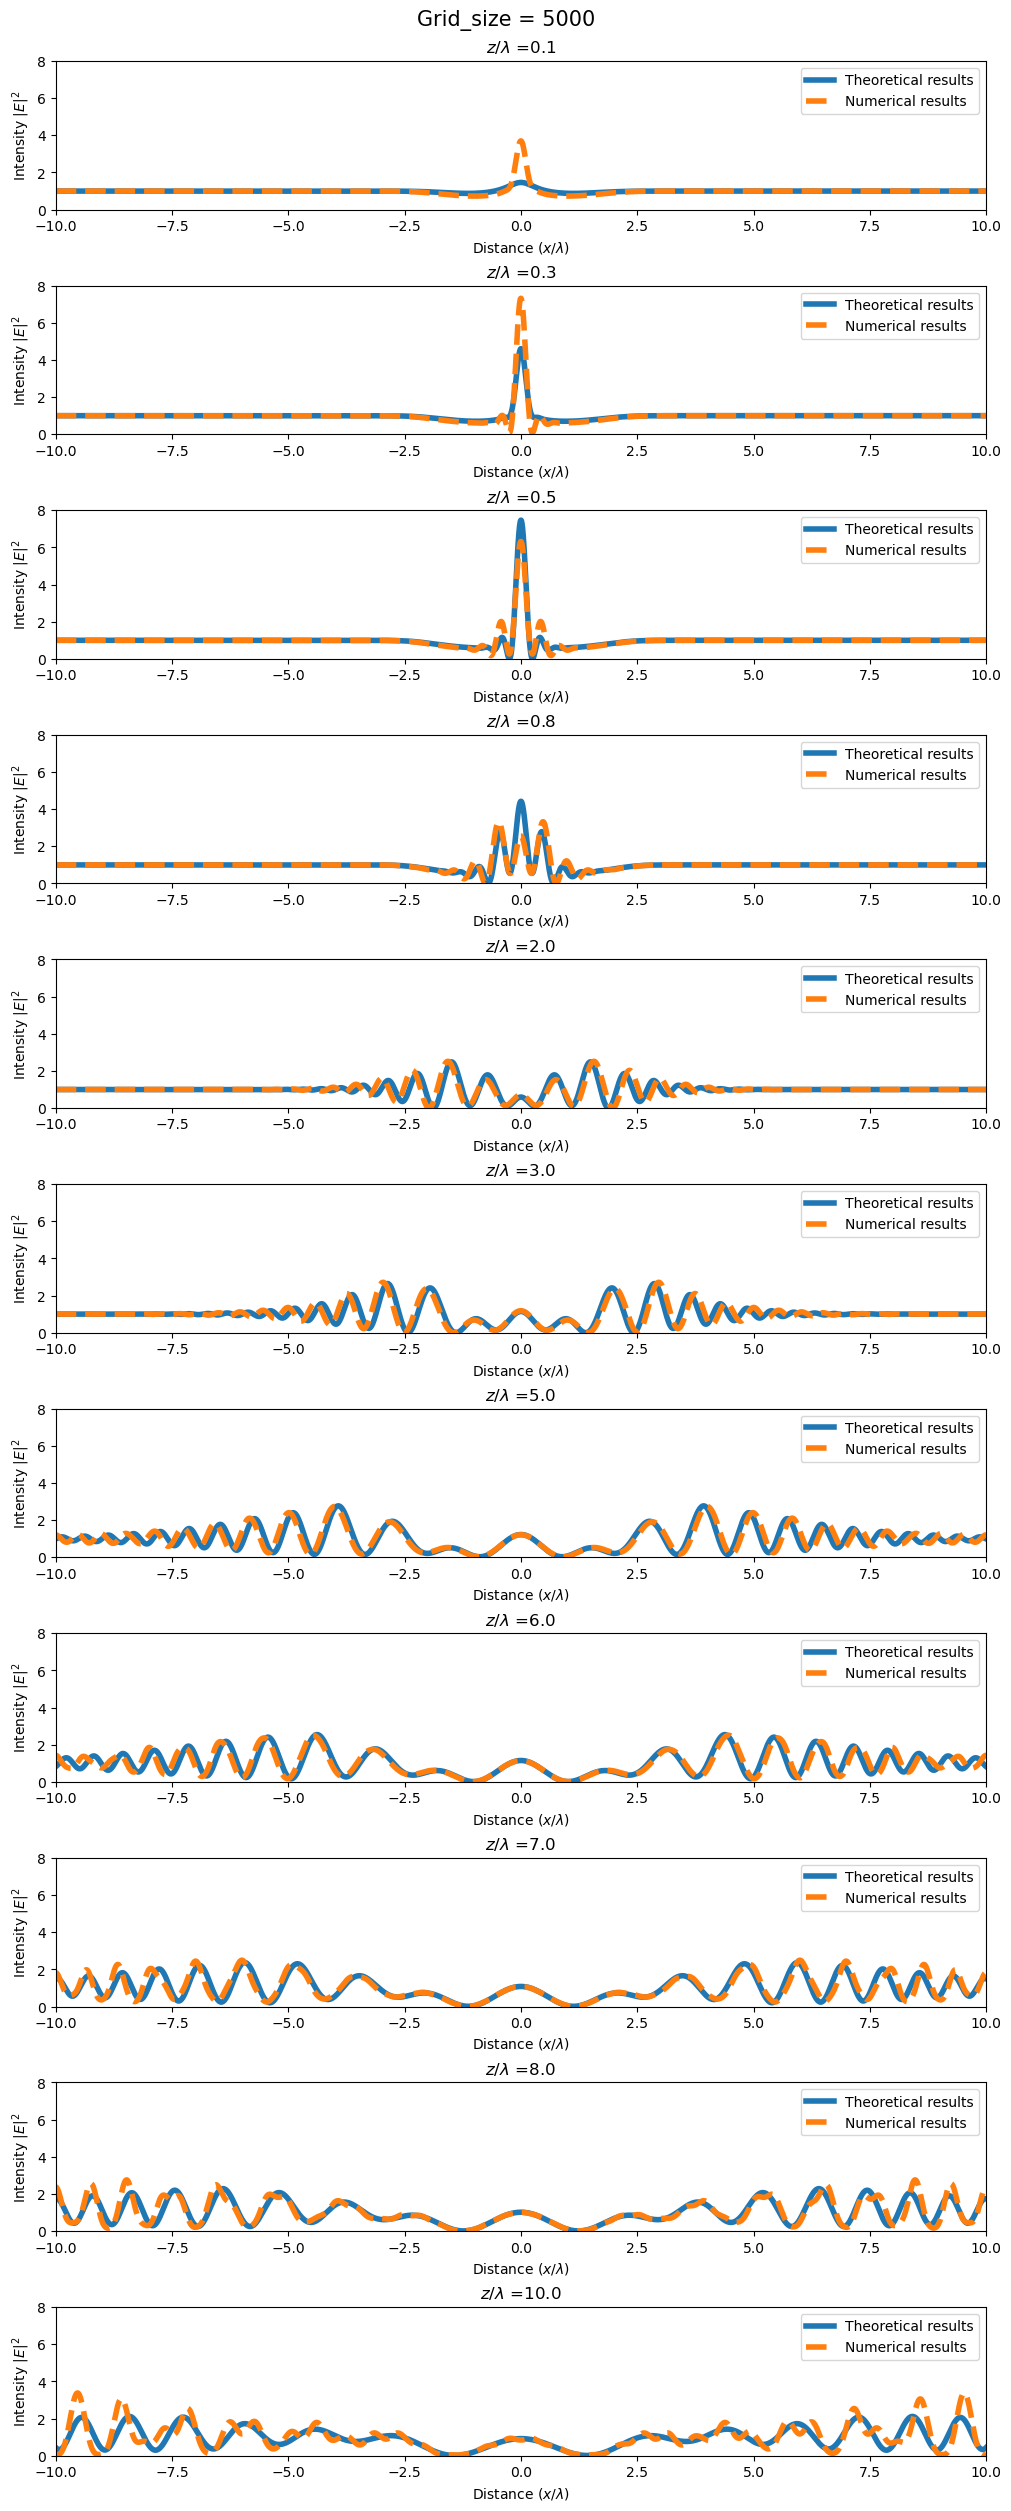

In [6]:

# Constants 
freq = 1e9
wavelength = 3e8/freq
phi0 = 10  # phi0 in radians
r0 = wavelength
grid_size = 5000  # Number of grid points
L = 6 # Length of the observation grid
Z_lambda = [0.1, 0.3, 0.5, 0.8, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 10.0]
# Create phase screen and plot results
phase_screen_dec = PhaseScreenDec(wavelength, phi0, r0, grid_size, L, Z_lambda)
e_theoretical = E_theoretical(phase_screen_dec)



results_plotter_for_decCoord = PlotResultsDec(phase_screen_dec, e_theoretical)
results_plotter_for_decCoord.plot_results()



In [7]:
class PhaseScreenCyl:
    def __init__(self, wavelength, phi0 ,grid_size, R, Grid_theta, r,  dr_lambda, r0):
        self.wavelength = wavelength
        self.phi0 = phi0
        self.grid_size = grid_size
        self.R = R
        self.Grid_theta = Grid_theta
        self.r = r 
        self.dr_lambda = dr_lambda
        self.r0 = r0
        self.k = 2 * np.pi /self.wavelength  
        self.dtheta = self.Grid_theta/self.grid_size
        self.theta = np.arange(-self.Grid_theta/2, self.Grid_theta/2, self.dtheta)
        self.dr_values = [r * self.wavelength for r in self.dr_lambda]
        self.phi = -self.phi0 * np.exp(- (self.theta*self.R)**2 / (self.r0**2))






    def generation_of_phase_screen_cyl(self):
        K = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(self.grid_size, d=self.dtheta))
        numerical_results = []
        
        for dri in self.dr_values:
            U = np.ones(self.grid_size, dtype=complex)
            U *= np.exp(-1j * (self.phi - 1/(2*self.k)*(1/self.r - 1/(self.r + dri))) + np.log((self.r + dri)/self.r))
            U_fft = np.fft.fftshift(np.fft.fft(U))
            H = np.exp(-1j * K**2/(2*self.k)*(1/self.r - 1/(self.r + dri)))
            U_prop = np.exp(1j * self.k * dri)/self.r*np.fft.ifft(np.fft.ifftshift(self.r * U_fft * H))
        
            intensity = np.abs(U_prop)**2
            numerical_results.append(intensity)
            
        return numerical_results
    
    def plot_results(self):
        numerical_results = self.generation_of_phase_screen_cyl()

        fig, axs = plt.subplots(len(self.dr_values), 1, figsize=(10, 25), constrained_layout=True)
        fig.suptitle(r"Grid_size = " + f"{self.grid_size}", fontsize=15)

        for i, (dri, num_intensity) in enumerate(zip(self.dr_lambda, numerical_results)):
            axs[i].plot((self.theta*self.R)/self.wavelength, num_intensity, label="Numerical results", linewidth=4, linestyle="-")
            axs[i].set_title(r"$dr / \lambda$ =" + f"{dri}")
            axs[i].set_xlabel(r"Distance $(R * \theta / \lambda)$")
            axs[i].set_ylabel("Intensity $|E|^2$")
            # axs[i].set_xlim([-10, 10])
            # axs[i].set_ylim([0, 1])
            axs[i].legend()
        plt.savefig(f"{self.grid_size}_Cyl.png", dpi='figure')
        plt.show()



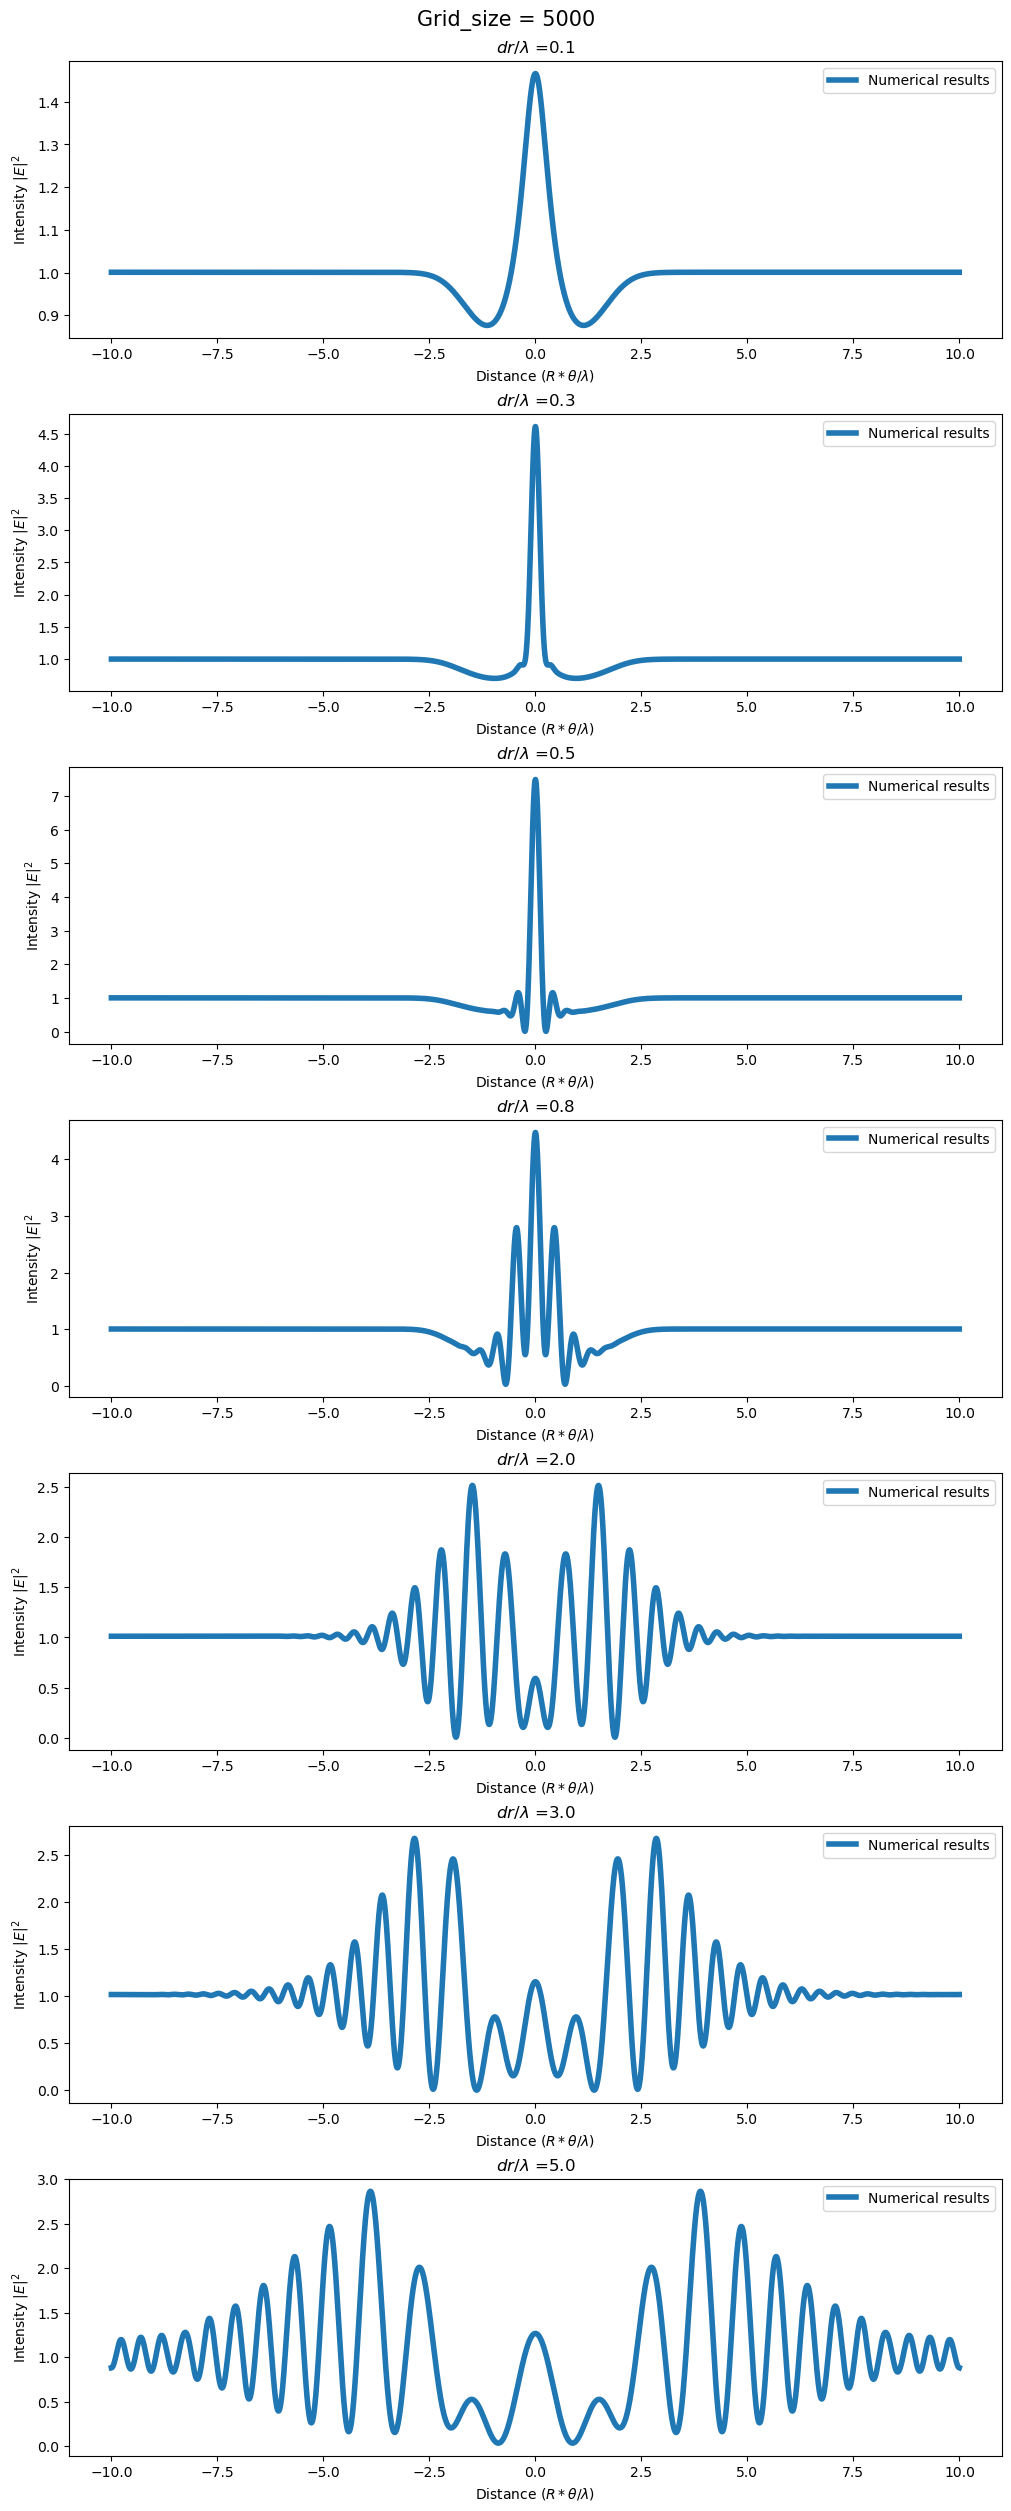

In [8]:
R = 100 #100 meters to source (it is radius of circle)
Grid_theta = 0.06 # radians
r = 100
r0 = wavelength
phi0 = 10  
grid_size = 5000 
dr_lambda = [0.1, 0.3, 0.5, 0.8, 2.0, 3.0, 5.0] 

phase_screen_cyl = PhaseScreenCyl(wavelength, phi0 ,grid_size, R, Grid_theta, r,  dr_lambda, r0)
phase_screen_cyl.plot_results()